In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 16

# 1. Dataset

In [4]:
from helpers.datasets import MnMsDataset
from helpers.utils import get_transforms

In [5]:
transforms = get_transforms()
train_dataset = MnMsDataset("csf", "./data/MnMs/", transforms, "train")
eval_dataset = MnMsDataset("csf", "./data/MnMs/", transforms, "eval")
test_dataset = MnMsDataset("csf", "./data/MnMs/", transforms, "test")
print(f"{len(train_dataset)}, {len(eval_dataset)}, {len(test_dataset)}")

632, 206, 148


384


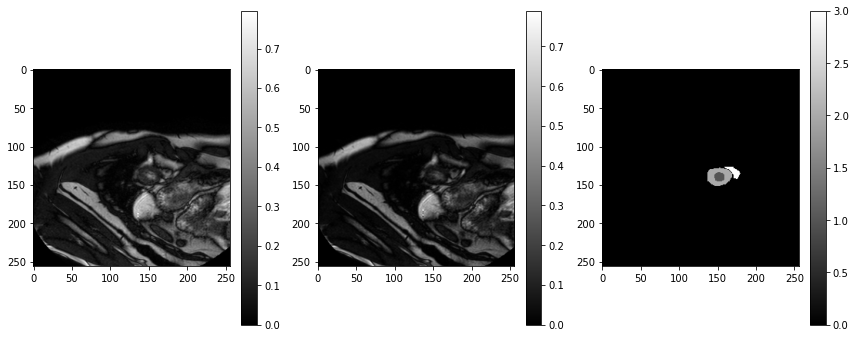

In [16]:
ind_test = np.random.randint(len(train_dataset))
print(ind_test)
# ind_test = 110
img, img1, mask = train_dataset[ind_test]
train_dataset.plot_triple(img[0], img1[0], mask[0], figsize=(12, 4.8))

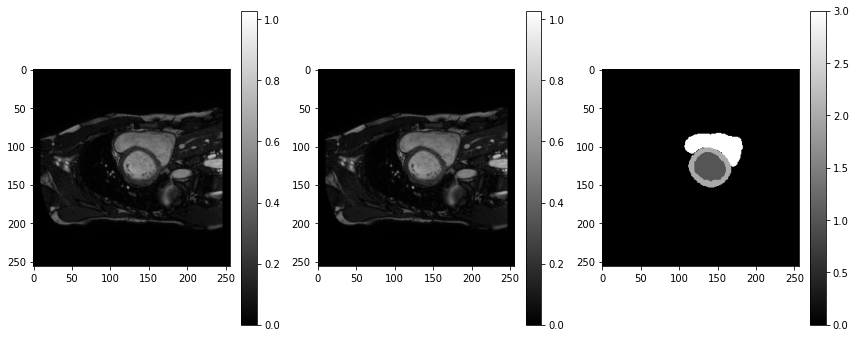

In [17]:
eval_ind = np.random.randint(len(eval_dataset))
img, mask = eval_dataset[eval_ind]
eval_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

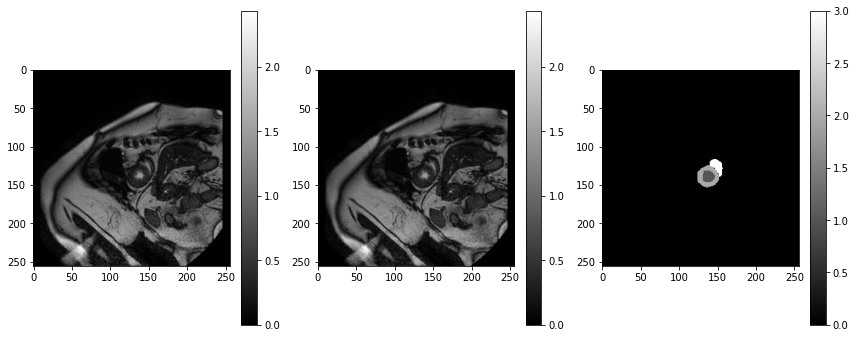

In [18]:
test_ind = np.random.randint(len(test_dataset))
img, mask = test_dataset[test_ind]
eval_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
for img, img1, mask in train_loader:
    print(f"{img.shape}, {img1.shape}, {mask.shape}")
    break

for img, mask in eval_loader:
    print(f"{img.shape}, {mask.shape}")
    break

for img, mask in test_loader:
    print(f"{img.shape}, {mask.shape}")
    break

torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256])


# 2. Model

In [11]:
from models.modules import Normalizer
from models.u_net import UNet

In [13]:
normalizer = Normalizer().to(DEVICE)
u_net = UNet(num_down_blocks=4, target_channels=4, in_channels=1).to(DEVICE)

In [14]:
norm_opt = torch.optim.Adam(normalizer.parameters())
u_net_opt = torch.optim.Adam(u_net.parameters())

# 3. Training